In [ ]:
import functools
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
import numpy as np
import pandas as pd
import random
import re
import sys
import time

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence
import torch.optim as optim
from torch.utils.data import Dataset
import torchtext


from tqdm import tqdm

## **CS 6120: Natural Language Processing - Prof. Ahmad Uzair** 

### **Final Project: Quora Question Pair - LSTM part**

In this notebook, our team construct a LSTM models using PyTorch and apply them on the Quora Question Pair kaggle competition. We optimize the model in various ways to get the best results (loss, accuracy, F1-score). Finally, we evaluate the performace of the model on various samples to confirm it performs well in most cases and also identify the gap for further improvement and future work.

Main references are the text book (Speech and Language Processing) and the LSTM paper (https://www.researchgate.net/publication/13853244_Long_Short-term_Memory).

In [ ]:
# Set the random seeds.
seed = 42
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)

In [ ]:
# Constant hyperparameters.
PAD_INDEX = 0
UNK_INDEX = 1
PAD_TOKEN = '<pad>'
UNK_TOKEN = '<unk>'
BATCH_SIZE = 128
EMBEDDING_DIM = 200
HIDDEN_DIM = 128
DROPOUT_RATE = 0.1
LR = 0.001
N_EPOCHS = 5

Load Data from the dataset from the "quora-question-pairs.zip" file in the googel drive. After unziped the file, in the folder, there are "train.csv.zip" and "test.csv.zip" two files.

Data source: Quora Question Pairs Kaggle Compitation
(https://www.kaggle.com/competitions/quora-question-pairs/data)

In [ ]:
train_df = pd.read_csv('train.csv.zip')
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            404290 non-null  int64 
 1   qid1          404290 non-null  int64 
 2   qid2          404290 non-null  int64 
 3   question1     404289 non-null  object
 4   question2     404288 non-null  object
 5   is_duplicate  404290 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


In [ ]:
# drop rows with null
train_df.dropna(inplace=True)
train_df.reset_index(drop=True,inplace=True)
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404287 entries, 0 to 404286
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            404287 non-null  int64 
 1   qid1          404287 non-null  int64 
 2   qid2          404287 non-null  int64 
 3   question1     404287 non-null  object
 4   question2     404287 non-null  object
 5   is_duplicate  404287 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


# Data Preprocessing

- Load GloVe pre-trained embeddings
- Tokenize the texts
- Prepare the dataloader

## Load pre-trained GloVe vectors
Pre-trained Glove word vectors: https://nlp.stanford.edu/data/glove.twitter.27B.zip

In [ ]:
# Load the pretrained Glove model
path_to_glove_file = 'glove.twitter.27B/glove.twitter.27B.{}d.txt'.format(EMBEDDING_DIM)

vocab, embeddings = [], []
count = 0
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = [float(val) for val in coefs.split(' ')]
        # filter out the invalid line(space does not need to be embedded)
        if len(coefs) != 200:
            continue
        vocab.append(word)
        embeddings.append(coefs)
        count += 1

print("Found %s word vectors." % len(vocab))

# vocab: a list of words, which will be useful in the text to token ids conversion step
# embeddings: a list of embeddings, this will be used to initialise the embeddings layer
vocab_npa = np.array(vocab)
embs_npa = np.array(embeddings)


# insert '<pad>' and '<unk>' tokens at start of vocab_npa.
vocab_npa = np.insert(vocab_npa, PAD_INDEX, PAD_TOKEN)
vocab_npa = np.insert(vocab_npa, UNK_INDEX, UNK_TOKEN)
print(vocab_npa[:10])

Found 1193513 word vectors.
['<pad>' '<unk>' '<user>' '.' ':' 'rt' ',' '<repeat>' '<hashtag>'
 '<number>']


In [ ]:
pad_emb_npa = np.zeros((1,embs_npa.shape[1]))   #embedding for '<pad>' token.
unk_emb_npa = np.mean(embs_npa,axis=0,keepdims=True)    #embedding for '<unk>' token.

#insert embeddings for pad and unk tokens at top of embs_npa.
embs_npa = np.vstack((pad_emb_npa,unk_emb_npa,embs_npa))
print(embs_npa.shape)

(1193515, 200)


## Tokenization + Dataset
- build vocabulary dictionary: word => index
- implement the tokenization method
- define the dataset class

In [ ]:
vocab = {}
for i, word in enumerate(vocab_npa):
    vocab[word] = i

In [ ]:
def tokenize(vocab: dict, example: str)-> list:
    """
    Tokenize the give example string into a list of token indices.
    :param vocab: dict, the vocabulary.
    :param example: a string of text.
    :return: a list of token indices.
    """
    words = str(example).split()
    indices = []
    for word in words:
        indices.append(vocab.get(word.lower(), vocab[UNK_TOKEN]))
    return indices

In [ ]:
class QuestionPair(Dataset):
    # Implement the Dataset module for constructing the dataloader below
    def __init__(self, q1, q2, y, vocab, max_length=256) -> None:
        """
        :param q1: list of question1
        :param q2: list of question2
        :param y: list of labels
        :param vocab: vocabulary dictionary {word:index}.
        :param max_length: the maximum sequence length.
        """
        self.x1 = q1
        self.x2 = q2
        self.y = y
        self.vocab = vocab
        self.max_length = max_length

    def __getitem__(self, idx: int):
        """
        Return the tokenized question pairs and label by the given index.
        :param idx: index of the sample.
        :return: a dictionary containing three keys: 'q1_ids', 'q2_ids', 'length', 'label' which represent the list of token ids, the length of the sequence, the binary label.
        """
        label = self.y[idx]
        q1_text = self.x1[idx]
        q2_text = self.x2[idx]
        q1_ids = tokenize(self.vocab, q1_text)
        q2_ids = tokenize(self.vocab, q2_text)
        if len(q1_ids) > self.max_length:
            q1_ids = q1_ids[:self.max_length]
        if len(q2_ids) > self.max_length:
            q2_ids = q2_ids[:self.max_length]
        res = {'q1_ids': q1_ids, 'q2_ids': q2_ids, 'q1_length': len(q1_ids), 'q2_length': len(q2_ids), 'label': label}
        return res
        
    def __len__(self) -> int:
        return len(self.x1)

def collate(batch, pad_index):
    """
    This is for the torch DataLoader: Pre-process the data list and pack them as a dict batch by batch
    :batch: list of dicts containing the question pairs
    :pad_index: index for the pad token
    :return: a dict packing the batch
    """
    q1_ids = [torch.LongTensor(i['q1_ids']) for i in batch]
    q1_ids = nn.utils.rnn.pad_sequence(q1_ids, padding_value=pad_index, batch_first=True)
    q1_length = torch.Tensor([i['q1_length'] for i in batch])
    q2_ids = [torch.LongTensor(i['q2_ids']) for i in batch]
    q2_ids = nn.utils.rnn.pad_sequence(q2_ids, padding_value=pad_index, batch_first=True)
    q2_length = torch.Tensor([i['q2_length'] for i in batch])
    batch_label = torch.LongTensor([i['label'] for i in batch])
    batch = {'q1_ids': q1_ids, 'q2_ids': q2_ids, 'q1_length': q1_length, 'q2_length': q2_length, 'label': batch_label}
    return batch

## DataLoader
- Train/test data split with the help of sklearn method
- Dataloader Construction based on the QuestionPair class above

In [ ]:
#split data to train and validation sets
train_df, val_df = train_test_split(train_df, test_size=0.1, random_state=42)

In [ ]:
# creates datasets
collate = functools.partial(collate, pad_index=PAD_INDEX)
train_data = QuestionPair(
                q1=train_df["question1"].values,
                q2=train_df["question2"].values,
                y=train_df["is_duplicate"].values,
                vocab=vocab
                )

val_data = QuestionPair(
                q1=val_df["question1"].values,
                q2=val_df["question2"].values,
                y=val_df["is_duplicate"].values,
                vocab=vocab
                )

# create dataloader for pytorch network
train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, collate_fn=collate)
valid_dataloader = torch.utils.data.DataLoader(val_data, batch_size=BATCH_SIZE, collate_fn=collate)

# Define and Train the LSTM-based Network

There are two separate LSTM models at the same layer for pair of documents. Padding and Embedding before the LSTM layer, then merge the two vectors together to  the Batch Normalization Layer, Dropout Layer and Linear Layer. After a Non-linear function, repeat these three layers to get the prediction.

In [ ]:
class SimilarNetwork(nn.Module):
    # The network definition
    def __init__(self, first_linear_dims=64, third_linear_dims=32):
        # Two separate LSTM layers for two documents
        super().__init__()
        self.hidden_size = 128
        self.input_size = EMBEDDING_DIM
        self.num_layers = 1
        self.bidirectional = False
        self.num_directions = 1
        self.dropout = nn.Dropout(p=DROPOUT_RATE)
        self.nonlinear = nn.PReLU()

        if self.bidirectional:
            self.num_directions = 2
        
        self.embedding = nn.Embedding.from_pretrained(torch.from_numpy(embs_npa).float())
        self.lstm1 = nn.LSTM( self.input_size, self.hidden_size, self.num_layers, 
                             bidirectional=self.bidirectional)
        self.lstm2 = nn.LSTM( self.input_size, self.hidden_size, self.num_layers, 
                             bidirectional=self.bidirectional )
        self.batchnorm1 = nn.BatchNorm1d(2 * self.hidden_size*self.num_directions)
        self.fc3 = nn.Linear(2 * self.hidden_size*self.num_directions, third_linear_dims)
        self.batchnorm2 = nn.BatchNorm1d(third_linear_dims)
        self.final_layer = nn.Linear(third_linear_dims, 2)
        
    def forward(self, q1, q2, length1, length2):
        q1 = self.pad_sequence(q1, length1)
        q2 = self.pad_sequence(q2, length2)
        emb1  = self.embedding(q1)
        emb2 = self.embedding(q2)
        emb1 = nn.utils.rnn.pack_padded_sequence(emb1, length1, batch_first=True, enforce_sorted=False)
        emb2 = nn.utils.rnn.pack_padded_sequence(emb2, length2, batch_first=True, enforce_sorted=False)
        _, (h1, c1) = self.lstm1(emb1)
        _, (h2, c2) = self.lstm2(emb2)
        merged = torch.cat((h1[-1], h2[-1]), 1) 
        out = self.batchnorm1(merged)
        out = self.dropout(out)
        out = self.fc3(out)
        out = self.nonlinear(out)
        out = self.batchnorm2(out)
        out = self.dropout(out)
        out = self.final_layer(out)
        return out
    
    def pad_sequence(self, ids:torch.Tensor, length:torch.Tensor):
        """
        pad the question id sequence so that it can be fed into the network
        :ids: the tensor before padding
        :length: a tensor of different length 
        :return: the tensor after padding
        """
        seq_len = torch.max(length)
        out_dims = (ids.size(0), int(seq_len))
        out_tensor = ids[0].data.new(*out_dims).fill_(PAD_INDEX)
        for i, tensor in enumerate(ids):
            len = tensor.size(0)
            out_tensor[i, :len, ...] = tensor
        return out_tensor

In [ ]:
is_cuda = torch.cuda.is_available()
if is_cuda:
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print(device)

cuda


In [ ]:
# initialize the network
similar_model = SimilarNetwork()
similar_model = similar_model.to(device)

# initialize the loss function, optimizer and a scheduler for Adam optimizer
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(similar_model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

## Define the training and evaluation function

In [ ]:
# training function for the LSTM based model called each epoch, trained batch by batch with loss and accuracy calculated.
def train(dataloader, model, criterion, optimizer, device):
    model.train()
    epoch_losses = []
    epoch_accs = []

    for batch in tqdm(dataloader, desc='training...', file=sys.stdout):
        # inputs
        q1_ids = batch['q1_ids'].to(device)
        q2_ids = batch['q2_ids'].to(device)
        length1 = batch['q1_length']
        length2 = batch['q2_length']
        label = batch['label'].to(device)
        # predict
        prediction = model(q1_ids, q2_ids, length1, length2)
        loss = criterion(prediction, label)
        accuracy = get_accuracy(prediction, label)
        # zero gradients
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_losses.append(loss.item())
        epoch_accs.append(accuracy.item())

    return epoch_losses, epoch_accs

# Evaluation function that computes the loss, acurracy score and f1 score, executed after epoch. 
def evaluate(dataloader, model, criterion, device):
    model.eval()
    epoch_losses = []
    epoch_accs = []
    labels = []
    predicted = []

    with torch.no_grad():
        for batch in tqdm(dataloader, desc='evaluating...', file=sys.stdout):
            # inputs
            q1_ids = batch['q1_ids'].to(device)
            q2_ids = batch['q2_ids'].to(device)
            length1 = batch['q1_length']
            length2 = batch['q2_length']
            label = batch['label'].to(device)
            # predict
            prediction = model(q1_ids, q2_ids, length1, length2)
            loss = criterion(prediction, label)
            accuracy = get_accuracy(prediction, label)
            epoch_losses.append(loss.item())
            epoch_accs.append(accuracy.item())
            labels += label.cpu().tolist()
            predicted += prediction.cpu().argmax(dim=-1)

    return epoch_losses, epoch_accs, f1_score(labels, predicted)

# Print the report with the help of classification_report function from sklearn
def report(dataloader, model, device):
    model.eval()
    labels = []
    predicted = []
    with torch.no_grad():
        for batch in tqdm(dataloader, desc='evaluating...', file=sys.stdout):
            q1_ids = batch['q1_ids'].to(device)
            q2_ids = batch['q2_ids'].to(device)
            length1 = batch['q1_length']
            length2 = batch['q2_length']
            label = batch['label'].cpu().tolist()
            prediction = model(q1_ids, q2_ids, length1, length2)
            predicted_classes = prediction.cpu().argmax(dim=-1)
            labels += label
            predicted += predicted_classes
    target_names = ['not duplicate', 'duplicate']
    print(classification_report(labels, predicted, target_names=target_names))

def get_accuracy(prediction, label):
    """
    Calculate the accuracy of based on the prediction labels and ground truth labels
    :prediction: the prediction labels
    :label: the ground truth labels
    :return: accuracy value
    """
    batch_size, _ = prediction.shape
    predicted_classes = prediction.argmax(dim=-1)
    correct_predictions = predicted_classes.eq(label).sum()
    accuracy = correct_predictions / batch_size
    return accuracy

## Train
For each epoch, train on the training dataset and evaluate on the 
validation dataset, during which keep track of the values of loss, 
accuracy and f1 score. Save the model with the lowest loss value during 
these epoches. In the end, plot the three diagrams for these three 
scores.

evaluating...: 100%|██████████| 316/316 [00:09<00:00, 32.18it/s]
epoch: 1
train_loss: 0.526, train_acc: 0.729
valid_loss: 0.481, valid_acc: 0.760
evaluating...: 100%|██████████| 316/316 [00:04<00:00, 68.73it/s]
epoch: 2
train_loss: 0.463, train_acc: 0.771
valid_loss: 0.455, valid_acc: 0.776
evaluating...: 100%|██████████| 316/316 [00:04<00:00, 69.86it/s]
epoch: 3
train_loss: 0.427, train_acc: 0.793
valid_loss: 0.439, valid_acc: 0.786
evaluating...: 100%|██████████| 316/316 [00:04<00:00, 68.36it/s]
epoch: 4
train_loss: 0.397, train_acc: 0.812
valid_loss: 0.434, valid_acc: 0.793
evaluating...: 100%|██████████| 316/316 [00:04<00:00, 70.28it/s]
epoch: 5
train_loss: 0.370, train_acc: 0.828
valid_loss: 0.434, valid_acc: 0.797
CPU times: user 5min 28s, sys: 58.1 s, total: 6min 26s
Wall time: 6min 29s


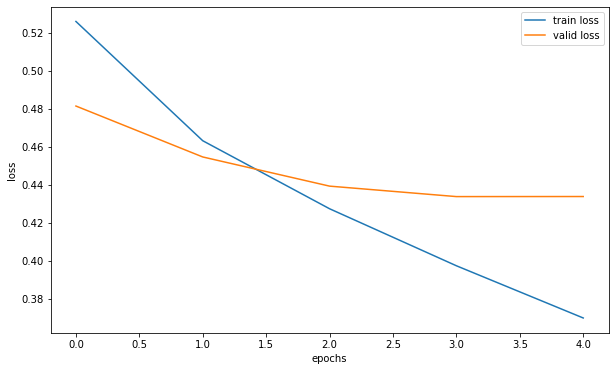

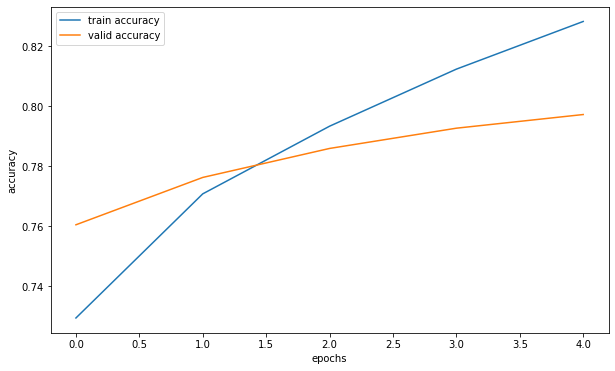

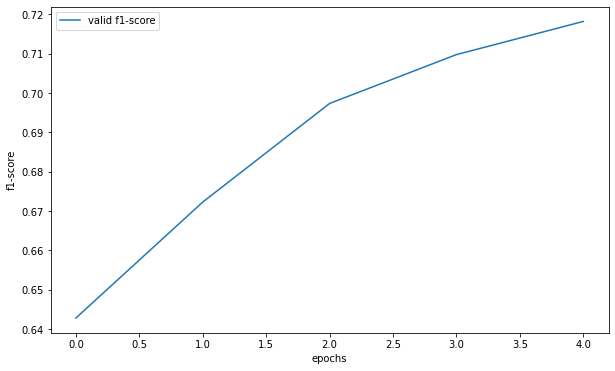

In [ ]:

%%time
# used for printing out the time cost for this cell(approximately the training time)
# Start training
best_valid_loss = float('inf')
train_losses = []
train_accs = []
valid_losses = []
valid_accs = []
valid_f1 = []

# For each epoch, train on the train dataset and evaluation on the validation dataset, keep track of the model with lowest loss value
for epoch in range(N_EPOCHS):
    train_loss, train_acc = train(train_dataloader, similar_model, criterion, optimizer, device)
    scheduler.step()
    valid_loss, valid_acc, f1 = evaluate(valid_dataloader, similar_model, criterion, device)

    epoch_train_loss = np.mean(train_loss)
    epoch_train_acc = np.mean(train_acc)
    epoch_valid_loss = np.mean(valid_loss)
    epoch_valid_acc = np.mean(valid_acc)
    
    train_losses.append(epoch_train_loss)
    train_accs.append(epoch_train_acc)
    valid_losses.append(epoch_valid_loss)
    valid_accs.append(epoch_valid_acc)
    valid_f1.append(f1)

    # Save the model that achieves the smallest validation loss.
    if epoch_valid_loss < best_valid_loss:
        best_valid_loss = epoch_valid_loss
        torch.save(similar_model.state_dict(), 'lstm.pt')

    print(f'epoch: {epoch+1}')
    print(f'train_loss: {epoch_train_loss:.3f}, train_acc: {epoch_train_acc:.3f}')
    print(f'valid_loss: {epoch_valid_loss:.3f}, valid_acc: {epoch_valid_acc:.3f}')


# Plot training and validation losses.
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(1,1,1)
ax.plot(train_losses, label='train loss')
ax.plot(valid_losses, label='valid loss')
plt.legend()
ax.set_xlabel('epochs')
ax.set_ylabel('loss')
plt.savefig("lstm_loss"+".png")

# Plot training and validation accuracies.
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(1,1,1)
ax.plot(train_accs, label='train accuracy')
ax.plot(valid_accs, label='valid accuracy')
plt.legend()
ax.set_xlabel('epochs')
ax.set_ylabel('accuracy')
plt.savefig("lstm_accuracy"+".png")

# Plot validation f1 score.
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(1,1,1)
ax.plot(valid_f1, label='valid f1-score')
plt.legend()
ax.set_xlabel('epochs')
ax.set_ylabel('f1-score')
plt.savefig("lstm_f1"+".png")

# Calculate the performance on the validation set
Load the trained model, calculate the metrics like precision, recall 
and f1 score by feeding the validation dataset into the model.

In [ ]:
# Load the model's weights.
model = SimilarNetwork()
model = model.to(device)
model.load_state_dict(torch.load('lstm.pt'))

report(valid_dataloader, model, device)

evaluating...: 100%|██████████| 316/316 [00:04<00:00, 73.44it/s]
               precision    recall  f1-score   support

not duplicate       0.82      0.86      0.84     25407
    duplicate       0.74      0.68      0.71     15022

     accuracy                           0.79     40429
    macro avg       0.78      0.77      0.77     40429
 weighted avg       0.79      0.79      0.79     40429



# Submit the prediction results on the test dataset

In [ ]:
test_df = pd.read_csv('test.csv')
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2345796 entries, 0 to 2345795
Data columns (total 3 columns):
 #   Column     Dtype 
---  ------     ----- 
 0   test_id    int64 
 1   question1  object
 2   question2  object
dtypes: int64(1), object(2)
memory usage: 53.7+ MB


In [ ]:
collate = functools.partial(collate, pad_index=PAD_INDEX)
# Construct the dataloader based on the test dataset
test_data = QuestionPair(
                q1=test_df["question1"].values,
                q2=test_df["question2"].values,
                y=[0] * len(test_df["question2"].values),
                vocab=vocab
                )

test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=BATCH_SIZE, collate_fn=collate)

In [ ]:
model.eval()
# predict on test question pairs
predicts = torch.empty(0).to(device)
with torch.no_grad():
    for batch in tqdm(test_dataloader, desc='evaluating...', file=sys.stdout):
        q1_ids = batch['q1_ids'].to(device)
        q2_ids = batch['q2_ids'].to(device)
        length1 = batch['q1_length']
        length2 = batch['q2_length']
        prediction = model(q1_ids, q2_ids, length1, length2)
        predicts = torch.cat((predicts, nn.Sigmoid()(prediction) ))

evaluating...: 100%|██████████| 18327/18327 [04:10<00:00, 73.06it/s]


In [ ]:
# Write the result to csv file, which will be submitted manually to Kaggle
test_df['is_duplicate'] = predicts.cpu().numpy().squeeze()[:, 1:]
test_df[['test_id', 'is_duplicate']].to_csv('submission.csv', index=False)